In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [2]:
# invariant parameters 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 30, # num particles (==== 30 instead of 10 ====)
    β = 0.2, # rate parameter
    t = 0.:0.01:30., # time steps to save (==== 30 instead of 10 ====)
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility,
    ρ_max = 2.0,
    g_print_lower = -30, # print verbose statistics if g is lower than this
    g_print_upper = 15) # print verbose statistics if g is higher than this

#3 (generic function with 2 methods)

In [3]:
# generator functions
function generate_jump_prob(p, rate_index, affect_index!)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        # g calculated w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        # verbose g logic
        if g < integrator.p.g_print_lower || g > integrator.p.g_print_upper 
            @show moments # current period moments
            if length(integrator.p.moments) > 0 
                @show integrator.p.moments[end] # last period moments (haven't pushed yet)
            end
        end
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

### Default (Broken) Output

moments = [-6.16541, -0.0303451, -0.00429661, 2.46891, 16.2198]
(integrator.p).moments[end] = [-17.1495, -0.192543, 0.0761772, 2.47301, -10.4152]
moments = [-2.87976, 1.14488, 1.17751, 3.49082, -86.4061]
(integrator.p).moments[end] = [-2.85008, 2.00894, 1.5519, 10.5683, 3.35152]
moments = [-2.74666, 1.1616, 1.25696, 3.64214, -81.4124]
(integrator.p).moments[end] = [-20.0707, 1.97573, 1.80956, 29.3936, 3.08101]
moments = [-6.37509, -0.316519, -0.0309104, 2.41602, 20.0283]
(integrator.p).moments[end] = [-19.7687, -0.516802, 0.00996826, 2.4181, -12.763]
moments = [-3.83998, 0.261944, 0.0537349, 2.57874, -48.6897]
(integrator.p).moments[end] = [-2.35596, 0.748842, 0.701781, 4.03476, 12.3787]
moments = [-2.34114, 0.696238, 0.545212, 8.24752, 21.4861]
(integrator.p).moments[end] = [-2.96798, 0.481377, 0.143267, 2.63119, 4.27949]
moments = [-3.70686, 0.911099, 0.691782, 14.5349, 21.4861]
(integrator.p).moments[end] = [-2.34114, 0.696238, 0.545212, 8.24752, 21.4861]
moments = [-5.37192, 1.1259

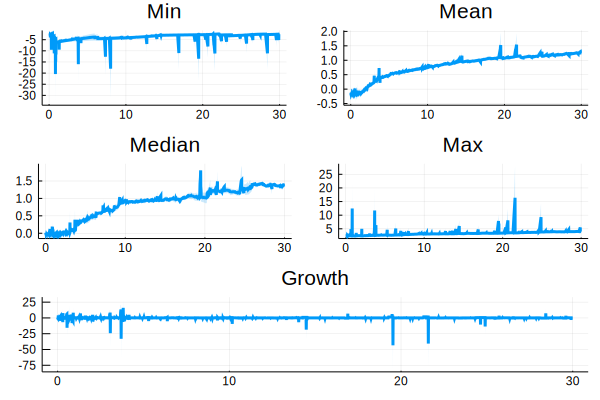

In [4]:
function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### New Algorithm

In [5]:
p = params(jump_algorithm = SOSRI())
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

moments = [-68.6759, -0.981042, 0.0742172, 2.94782, -106.174]
(integrator.p).moments[end] = [-3.48112, 0.0806987, 0.316318, 2.03316, 0.2813]
moments = [-3.47599, 0.0558925, 0.303199, 2.05806, 103.693]
(integrator.p).moments[end] = [-68.6759, -0.981042, 0.0742172, 2.94782, -106.174]
moments = [-35.4987, -0.32213, 0.45197, 2.05597, -59.0307]
(integrator.p).moments[end] = [-4.45456, 0.268176, 0.491856, 2.20766, 0.14337]
moments = [-4.45208, 0.25098, 0.485334, 2.20353, 57.3111]
(integrator.p).moments[end] = [-35.4987, -0.32213, 0.45197, 2.05597, -59.0307]
moments = [-4.37709, 0.268554, 0.487709, 2.32872, 15.9007]
(integrator.p).moments[end] = [-10.7873, 0.109547, 0.407916, 2.57348, -14.8961]
moments = [-4.77462, 0.552143, 0.936888, 3.07922, 30.7924]
(integrator.p).moments[end] = [-31.7498, 0.244218, 0.856256, 12.9589, -18.4777]
moments = [-100.225, -1.43682, -0.00468077, 24.5153, -125.893]
(integrator.p).moments[end] = [-4.53229, -0.177888, -0.00448208, 1.5143, 0.128209]
moments = [-4.5188

### No Affect

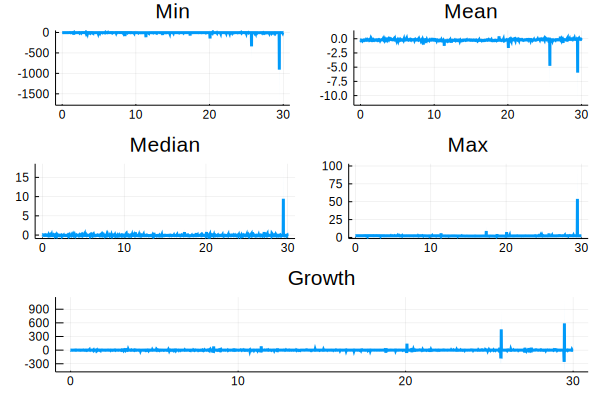

In [6]:
affect_index!(integrator, index) = nothing

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### No Variable Rate

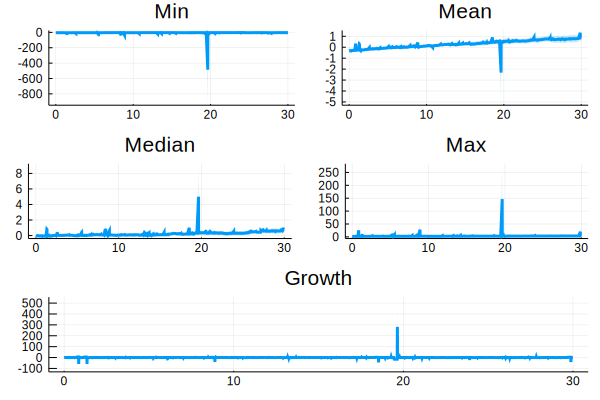

In [7]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)])) # original 

p = params(g_print_lower = -500, g_print_upper = 1000)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### Neither Affect nor Variable Rate

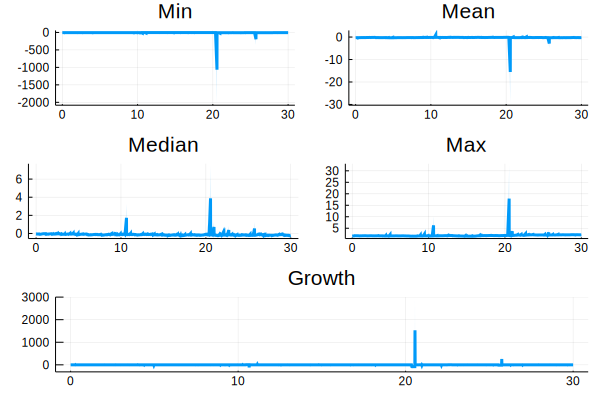

In [8]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
affect_index!(integrator, index) = nothing

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)

### ConstantRateJump Sanity Check

In [9]:
# generator functions
function generate_jump_prob(p, rate_index, affect_index!)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [ConstantRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((), jumps, nothing, nothing))
    return jump_prob
end

function generate_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        # g calculated w.r.t. mean
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), median(u), maximum(u), g]
        # verbose g logic
        if g < integrator.p.g_print_lower || g > integrator.p.g_print_upper 
            @show moments # current period moments
            if length(integrator.p.moments) > 0 
                @show integrator.p.moments[end] # last period moments (haven't pushed yet)
            end
        end
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

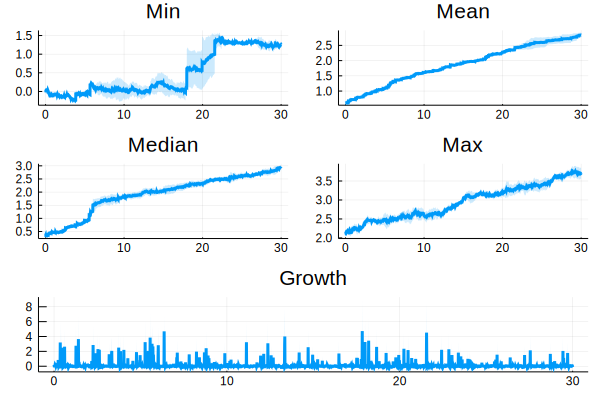

In [12]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)])) # original 

p = params(g_print_lower = -Inf, g_print_upper = Inf)
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Median")
p4 = plot(summ, idxs = [4], title = "Max")
p5 = plot(summ, idxs = [5], title = "Growth")
l = @layout [a b; c d ; d]

plot(p1, p2, p3, p4, p5, layout = l)